<h1 align=center>The Fisher-Wright Model Answers</h1>

We provide code to address all the questions.  Running the code and showing that you understand what the code is doing is sufficient to get 6/10.  If you want higher marks you should either write some of the code yourself or go beyond the answers given here.

## Task 1: Simulating Fisher-Wright

Write a program to simulate the Fisher-Wright model of evolution.  (To make it easy you can just copy the code below).

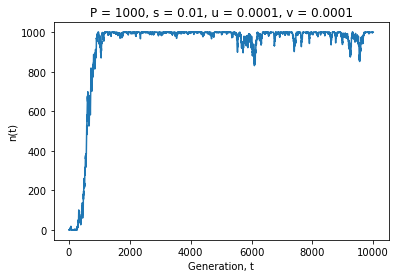

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

rng = np.random.default_rng()

def psm(n, P, s, u, v):
    """We heavily reuse this"""
    ps = (1+s)*n/(P+n*s)
    return (1-v)*ps + u*(1-ps)

def updateFW(n, P, s, u, v):
    """Generate a new population of size P starting with n individuals of type B"""
    return rng.binomial(P, psm(n, P, s, u, v))

class FisherWright():
    """Simulate the Dynamics of the Fisher-Wright Model
    We create an iterator to this"""
    
    def __init__(self, param):
        "create a function with the parameter set apart form n"
        self.update = partial(updateFW, **param)
        
    def __iter__(self):
        n = self.n0
        yield n
        while True:
            n = self.update(n)
            yield n

    def __call__(self, n0):
        """initiate n0 and return iterator"""
        self.n0 = n0
        return iter(self)

param = {"P": 1000, "s": 0.01, "u": 0.0001, "v": 0.0001}

fisherWright = FisherWright(param)

T = 10000

def evolution(model, n0, T, transform=lambda x: x):
    """Run the model for T generations starting from n0
        transform the output of the model with default of doing nothing"""
    it = model(n0)                # create a new iterator
    return [(i, transform(next(it))) for i in range(T)]


evo = evolution(fisherWright, 0, T)

def dict_to_str(dic):
    return ", ".join([f"{key} = {value}" for (key,value) in param.items()])

plt.plot(*zip(*evo))        # weird trick to get matplotlib to plot a list of (x,y) pairs
plt.xlabel("Generation, t")
plt.ylabel("n(t)")
plt.title(dict_to_str(param))
plt.show()

### Questions

1. Under what conditions does trait $B$ take over the population
2. Define the take-over time as the first time when $n(t) = 0.95 P$
- Plot a graph of how the take-over time depends on the selection strength $s$ (assume $P=10000$ and $u=v=0.0001$)
- Plot a graph of how the take-over time depends on the mutation rate $u=v=m$ (assuming $P=10000$ and $s=0.01$)
- Plot a graph of how the take-over time depends on the population size $P$ (assuming $s=0.01$ and $u=v=0.0001$)

## Task 2: Multiple Runs

The results from the previous question will vary from run to run.  To get a better understanding we can average over many runs.  Write a program to do this.

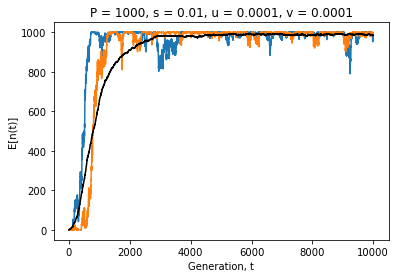

In [2]:
# average over 100 copies
no_runs = 100
multievo = evolution(fisherWright, np.zeros(no_runs), T, np.mean)

# Two single runs
evo1 = evolution(fisherWright, 0, T)
evo2 = evolution(fisherWright, 0, T)

plt.plot(*zip(*evo1), *zip(*evo2), *zip(*multievo), "-k")
plt.xlabel("Generation, t")
plt.ylabel("E[n(t)]")
plt.title(dict_to_str(param))
plt.show()

## Task 3: Markov Model

We can make a Markov model that describes the probability, $p(t,n)$, of there being $n$ individuals in generation $t$.  We can represent this probability as a vector $\mathbf{p}(t)$ where the $n^{th}$ elements represents $p(t,n)$.  We can build a transition matrix $\mathbf{W}$ where the element $W_{n',n}$ is the probability of the number of individuals with trait $B$ changing from $n$ to $n'$ in one geneation.  In this case we can compute the evolution using 
$$ \mathbf{p}(t+1) = \mathbf{W} \, \mathbf{p}(t). $$
Write a matrix to compute $\mathbf{W}$ for a population of size $P$ a selection strength $s$, and mutation rates $u$ and $v$.

In [3]:
from scipy.stats import binom
import math

def transition_matrix(P, s, u, v):
    n = np.arange(0,P+1)
    p = psm(n,P,s,u,v)
    return np.array([binom.pmf(nn, P, p) for nn in n])

W = transition_matrix(**param)

### Questions

1. Show that columns all sum to 1 (A population with $n$ individuals of type $B$ will evolve to a population of $n'$ individuals of type $B$ for some $n'$)
- Check for different parameters
2. Starting from $p(t,0)=1$ compute the evolution of $\mathbf{p}(t)$ and show a graph of the mean number of individuals.  Compare this to multiEvolution.
- Show that as we use more copies in multiEvolution we get closer to the Markov result
3. Plot $\mathbf{p}(100)$ and compare this with a histogram from multiEvolution.
- Show that this is true for both short and long times.

In [4]:
def veryCloseToOne(x):
    return abs(x-1)<1.0e-10

print("Columns all sum close to 1: ", all(veryCloseToOne(sum(W))))  # all(list) == True iff every element evaluate to True

Columns all sum close to 1:  True


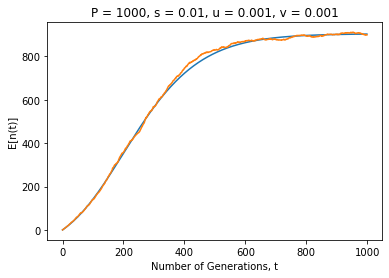

In [5]:
class MarkovChain():
    """Markov Chain Model for simulating the Fisher Wright Model"""
    
    def __init__(self, P, s, u, v):
        self.W = transition_matrix(P, s, u, v)
        self.n = range(P+1)
        self.P = P
        
    def __iter__(self):
        p = np.array(self.p0)
        yield p
        while True:
            p = self.W@p
            yield p
            
    def mean(self, p):
        return self.n@p
    
    def __call__(self, n):
        self.p0 = np.zeros(self.P+1)
        self.p0[n] = 1
        return iter(self)

T = 1000

param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001} # Speed up mutation

fisherWright = FisherWright(param)


markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

multievo = evolution(fisherWright, np.zeros(no_runs), T, np.mean)

plt.plot(*zip(*evoMarkov), *zip(*multievo))
plt.xlabel("Number of Generations, t")
plt.ylabel("E[n(t)]")
plt.title(dict_to_str(param))
plt.show()

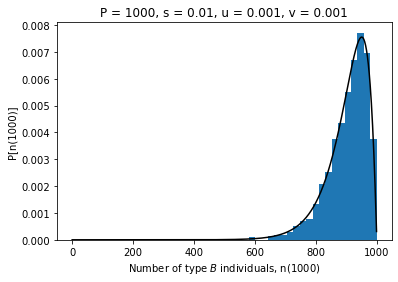

In [6]:
def distribution(model, n0, T):
    """Return the distribution of the Population After T iterations starting from n0"""
    it = model(n0)
    for _ in range(T-1):
        next(it)
    dist = next(it)
    return list(range(len(dist))), dist


# Use markovChain model
n, markovDist = distribution(markovChain, 0, T)

# Simulate 1000 runs
no_copies = 1000
_, multiDist = distribution(fisherWright, np.zeros(no_copies), T)

plt.hist(multiDist, 20, density=True)
plt.plot(n, markovDist, "k")
plt.xlabel(f"Number of type $B$ individuals, n({T})")
plt.ylabel(f"P[n({T})]")
plt.title(dict_to_str(param))
plt.show()
 

## Task 4: Computing the Fixed Point Distribution

The distribution eventually reaches a fixed point, $\mathbf{p}(\infty)$, for any starting distribution (under mild conditions such as non-zero mutation rates).  We can get a very good approximation by running the Markov analysis long enough (or running a simulation for long enough).  Note that although we call it a fixed-point or equilibrium the number of individuals of type $B$ will continuously fluctuate over time.  The relative fluctuation will be smaller in a larger population (i.e. $n(t)/P$ will closer to its expected value $\mathbb{E}[n(t)]/P = p(\infty,n)$.

We have an exact solution to the dynamics in terms of the Markov model, but it involves a $(P+1)\times(P+1)$ transition matrix which gets difficult to work with when $P$ becomes large.  We can simulate a population which is much more practical for large $P$, but we need to run many simulations if we want to compute the average dynamics or a distribution.  Instead we can use the diffusion model which provides a very good approximation for large populations.

In the diffusion model we set up a stochastic differential equation describing the evolution.  Let $X(t)$ be a random variable describing the proportion of individuals with trait $B$ in the population at time $t$.  In the diffusion approximation we approximate the dynamics by a *stochastic differential equation*
$$ \mathrm{d} X(t) = a(X(t))\, \mathrm{d} t + b(X(t)) \, \mathrm{d} W(t) $$
where $a(X(t))$ describes the expected change in $X(t)$ in a short time $\mathrm{d} t$.  That is,
$$ a(X(t))\,\mathrm{d}t = \mathbb{E}\left[ \strut X(t+\mathrm{d}t) - X(t) \right] = (p_{sm}(X(t)) - X(t))\,\mathrm{d}t  $$
and $b(X(t))$ describes the fluctuation around this mean. That is,
$$ b^2(X(t))\,\mathrm{d} t = \mathbb{E}\left[ \strut \left(X(t+\mathrm{d}t) - X(t)\right)^2 \right] - \mathbb{E}\left[ \strut X(t+\mathrm{d}t) - X(t) \right]^2 = \frac{p_{sm}(X(t))\,(1-p_{sm}(X(t)))\,\mathrm{d}t}{P} $$
The quantity $W(t)$ is known as a Weiner variable it has the property that $W(t)-W(t')$ is normally distributed with mean 0 and variance $t-t'$.  The stochastic differential equation is a weird mathematical object.  But the distribution $f(t,x)$ describing the probability of $X(t)$ satisfies the Kolmogorov forward equation
$$ \frac{\partial f(t,x)}{\partial t} = - \frac{\partial\, a(x)\,f(t,x)}{\partial x} + \frac{1}{2} \frac{\partial^2 b^2(x)\, f(t,x)}{\partial x^2}.$$
This is still pretty horrible as partial differential equations are a slight pain to solve (but it can be done).  However, to find the fixed point distribution we look for a solution where
$$ \frac{\partial f(t,x)}{\partial t} = 0. $$
In this case we find
$$ f(\infty, x) \propto \frac{1}{b^2(x)} \exp\!\left( 2 \int_{1/2}^x \frac{a(y)}{b^2(y)} \mathrm{d} y \right). $$
This is relatively easy to compute, although it is a bit of a pain to do all the integrations.

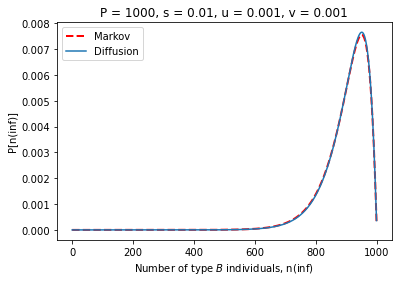

In [7]:
## Diffusion Approximation

class steadyStateDiffusion():
    """ Computes the diffusion approximation to the steady state"""
    
    def __init__(self, P, s, u, v):
        self.param = [P,s,u,v]
        self.P = P
        self.norm = 1
        self.norm, _ = scipy.integrate.quad(self.__call__, 0, P)
        self.norm *= 1

    def psm(self, x):
        _, s, u, v = self.param
        ps = (1+s)*x/(1+s*x)
        return ps*(1-v) + u*(1-ps)

    def integrand(self, x):
        p = self.psm(x)
        a = p-x
        bs = p*(1-p)/self.P
        return -2*a/bs

    def __call__(self, n):
        x = n/self.P
        p = self.psm(x)
        bs = p*(1-p)/self.P
        integral, _ = scipy.integrate.quad(self.integrand,x,0.5)
        return math.exp(integral)/(self.norm*bs)

param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001} # Speed up mutation

diffusion = steadyStateDiffusion(**param)

## Markov Solution after a long time
T= 1000
n, markovDist = distribution(markovChain, 0, T)

#fig = plt.figure(figsize=(12,8))
plt.plot(n, markovDist, "--r", linewidth=2, label="Markov")

diffResult = [diffusion(i) for i in n]

plt.plot(n, diffResult, label="Diffusion")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

**Weak Selection and Mutation Approximation**

It gets even easier if we assume the mutation and selection rates are small (this is a good assumption in biology).  In this case
$$  f(\infty, x) \propto x^{2\,P\,u-1} \, (1-x)^{2\,P\,v-1} \, \mathrm{e}^{2\,P\,s\,x}.$$

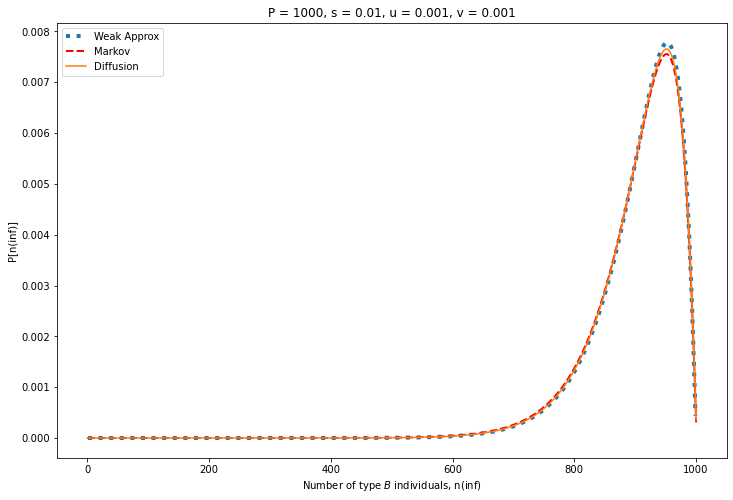

In [8]:
class steadyStateWeakApprox():
    """Computes the steady state using the approximation of weak mutation and selection"""
    
    def __init__(self, P, s, u, v):
        self.abc = 2*P*np.array([u, v, s])
        self.P = P
        a, b, c = self.abc
        self.norm = -math.log(P) - scipy.special.betaln(a,b) - math.log(scipy.special.hyp1f1(a, a+b, c))
        
    def __call__(self, n):
        x = n/self.P
        a, b, c = self.abc
        return np.exp((a-1)*np.log(x) + (b-1)*np.log(1-x) + c*x + self.norm)



fig = plt.figure(figsize=(12,8))  # Make the graph bigger

# Compute distribution using the weak selection/mutation approximation
weakApprox = steadyStateWeakApprox(**param)
nouter = np.array(n[1:-1])    # ignore x=0 and x=1 as logarithms don't like this
plt.plot(nouter, weakApprox(nouter), ":", linewidth=4, label="Weak Approx")


# Plot Markov result
plt.plot(n, markovDist, "r--", linewidth=2, label="Markov")

# Plot the diffusion approximation result
plt.plot(n, diffResult, label="Diffusion")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

Note that we can easily compute the steady state for very large systems

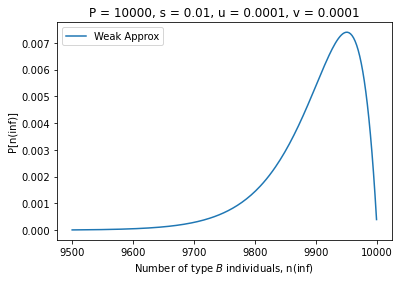

In [9]:
param = {"P": 10000, "s": 0.01, "u": 0.0001, "v": 0.0001}
weakApprox = steadyStateWeakApprox(**param)
n = np.linspace(param["P"]-500,param["P"]-1, 200)
plt.plot(n, weakApprox(n), label="Weak Approx")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

## Task 5: Multigene Evolution

Up to now we have considered the evolution of a single trait in isolation from any other genes.  Obviously in real evolution the genome will contain many genes that code for different traits.  Here we want to show that if we have sufficient sexual recombination the Fisher-Wright model still provides a good approximation for the evolution.  Here we model the genome as a series of $L$ sites (each site represents a gene which will be on a different section of the DNA.  At each site we assume that the gene can be in one of two states.  The original state and the mutant state.  Again we assume that for two individuals that differ at one site the one the differs by having an extra mutation will be fitter by a factor $1+s$.  That is, the fitness (the relative number of offspring) will be proportional to $(1+s)^F$ where $F$ is the number of mutants in the string.  To simulate this consider a populations of $P$ binary strings of length $L$.  A 0 at a site denotes that gene is in the original state while a 1 represents the gene being in a mutant state.  Initially we assume all strings are in the original state (all zeros).  The evolution happens in generations according to
1. We consider $P$ mating events where two parents are selected with probability
$$p_i = \frac{(1+s)^{F_i}}{\sum_{j=1}^P (1+s)^{F_j}} $$
where $F_i$ is the number of ones in individual $i$
2. For each pair we generate a child by at each site choosing the gene value from one parent or the other uniformly at random
3. We then mutate each child by flipping the gene at each site with a probability of $u$ of flipping from 0 to 1 and a probability of $v$ of flipping from 1 to 0.  For simplicity we can assume $v=u$.

Write a simulator to run this for $T$ generations.

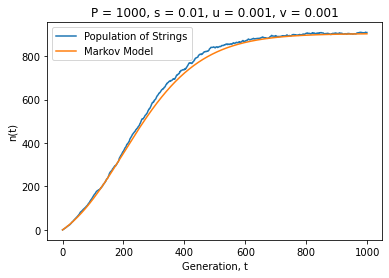

In [24]:
from bisect import bisect

class Population():
    """Container of Population"""
    
    def __init__(self, P, L):
        """create P genomes of length L initialised to 0 string"""
        self.pop = np.zeros((P,L), dtype=bool)
        self.P = P
        self.L = L
        
    def __getitem__(self, k):
        """return genome of individual k"""
        return self.pop[k,:]
    
    def __len__(self):
        """size of population"""
        return self.P
    
    def no_ones(self):
        """compute the number of 1's in each string"""
        return np.sum(self.pop, axis=1)
    
    def prob(self, s):
        """Compute the probability of seclecting each member"""
        F = self.no_ones()
        F -= max(F)            # prevent overflow
        w = pow(1.0+s, F)
        return w/sum(w)
    
    def choose_parents(self, n, s):
        """Choose n parents according to their fitness"""
        p = self.prob(s)
        cp = np.cumsum(p)
        r = np.random.rand(2*self.P)
        return [bisect(cp, rng.random()) for _ in range(n)]
    
    def crossover(self, m, f):
        """Create a child by choosing each allele from either parent with equal probability"""
        mask = np.random.randint(2,size=self.L)
        imask = 1 - mask
        return mask*self[f] + imask*self[m] 
        
    def recombine(self, s):
        """Generate a new population from 2 P parents selected according to their fitness"""
        n = self.choose_parents(2*self.P, s)
        newPop = Population(self.P, self.L)
        for m,f,c in zip(n[::2], n[1::2], range(self.P)):
            newPop.pop[c,:] = self.crossover(f,m)
        return newPop
    
    def selection(self, s):
        """Generate a new population asexually"""
        n = self.choose_parents(self.P, s)
        newPop = Population(self.P, self.L)
        for c, p in enumerate(n):
            newPop.pop[c,:] = self[p]
        return newPop
        
    def mutate(self, u):
        """Flip spins with probablity u
        It does this by drawing a random deviate representing the expected gap between mutations"""
        PL = self.P*self.L
        c = 1.0/math.log(1.0-u)
        flat = self.pop.view(dtype=bool).reshape(PL)
        s = int(c*math.log(np.random.rand()))
        while s < PL:
            flat[s] = 1-flat[s]
            s += int(c*math.log(np.random.rand()))
            
    def mutants_per_site(self):
        """We are interested in the frequency of mutations at each Site"""
        return np.sum(self.pop, axis=0)

    def __str__(self):
        """Create a nice sting showing the population of their fitness"""
        F = self.no_ones()
        s = ""
        for k in range(self.P):
            s += f"{k}: {1*self[k]} F={F[k]}\n"
        return s

class PopulationEvol():
    """Iterate Class to Evolve a Population"""
    
    def __init__(self, L, P, s, u):
        self.L = L
        self.P = P
        self.s = s
        self.u = u
        
    def __iter__(self):
        pop = Population(self.P, self.L)
        yield pop
        while True:
            pop = pop.recombine(self.s)
            pop.mutate(self.u)
            yield pop
            
    def __call__(self, dummy):
        return iter(self)
    
def meanFitness(pop):
    """Returns the mean number of mutations in the population"""
    return np.mean(pop.mutants_per_site())

# Run a Population of strings
paramGA = {"L": 100, "P": 1000, "s": 0.01, "u": 0.001}
modelGA = PopulationEvol(**paramGA)
T = 1000
evoGA = evolution(modelGA, None, T, meanFitness)

# Compare with Marov Model
param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001}
markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

plt.plot(*zip(*evoGA), label="Population of Strings")
plt.plot(*zip(*evoMarkov), label="Markov Model")
plt.xlabel("Generation, t")
plt.ylabel("n(t)")
plt.title(dict_to_str(paramGA))
plt.legend()
plt.show()

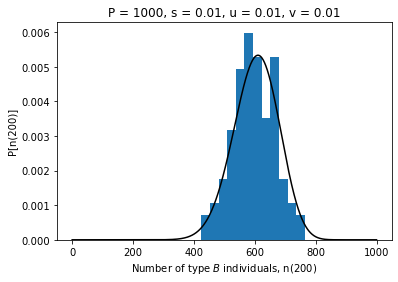

In [12]:
# Distribution in Population

n, markovDist = distribution(markovChain, 0, T)
modelGA = PopulationEvol(**paramGA)
_, gaDist = distribution(modelGA, 0, T)

plt.hist(gaDist.mutants_per_site(), 12, density=True)
plt.plot(n, markovDist, "k")
plt.xlabel(f"Number of type $B$ individuals, n({T})")
plt.ylabel(f"P[n({T})]")
plt.title(dict_to_str(paramGA))
plt.show()
 

### Asexual Evolution

Our model of the distributions of alleles at each site is a very good approximation in the case where there is random recombination that mixes the genes between parents.  If we consider an asexual population undergoing selection and mutation the dynamics is different and actually far harder to model.

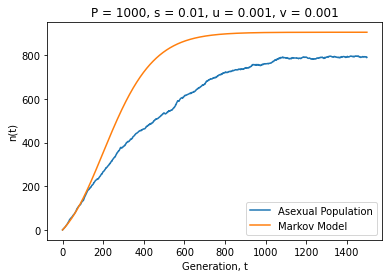

In [27]:
class PopulationAsexualEvol():
    """Iterate Class to Evolve a Population"""
    
    def __init__(self, L, P, s, u):
        self.L = L
        self.P = P
        self.s = s
        self.u = u
        
    def __iter__(self):
        pop = Population(self.P, self.L)
        yield pop
        while True:
            pop = pop.selection(self.s)
            pop.mutate(self.u)
            yield pop
            
    def __call__(self, dummy):
        return iter(self)

# Run a Population of strings
paramGA = {"L": 100, "P": 1000, "s": 0.01, "u": 0.001}
modelGAa = PopulationAsexualEvol(**paramGA)
T = 1500
evoGAa = evolution(modelGAa, None, T, meanFitness)

# Compare with Marov Model
param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001}
markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

plt.plot(*zip(*evoGAa), label="Asexual Population")
plt.plot(*zip(*evoMarkov), label="Markov Model")
plt.xlabel("Generation, t")
plt.ylabel("n(t)")
plt.title(dict_to_str(paramGA))
plt.legend()
plt.show()